# **任务9 卷积滑动窗口预测 CNN Sliding Window Prediction**

滑动窗口在任何维度的数据都可以使用，例如卷积核本质上也是一种滑动窗口，但在此案例中，这个滑动窗口指的是我们在一个连续的，有先后关系的数据中，按时间或空间顺序逐个以一定窗口范围内为输入，预测下一位的数值，例如续写：以前几个字或词作为输入预测下一个字，这种空间关系的数据同样可以使用卷积来提取特征。

这种具有先后顺序的数据（通常与时间有关）被称为时序数据，滑动窗口是处理时序预测的一个经典方案。

___

## 1. **数据生成**

这里我们需要先确定我们的任务需求再构建模型，正弦数的前几个数预测后续的数据，确保采样间隔相同。

检验方法是往后继续预测20位数

In [121]:
import torch
import torch.nn as nn

def get_data(data_size, test_mode=False, step=0.1, seq_len=20):
    # ===================== 1. 定义核心参数 =====================
    num_samples = data_size  # 总数据条数
    total_points = seq_len + 1  # 每个序列的总点数（用于生成X+Y）
    if test_mode:
        total_points = seq_len * 2

    # ===================== 2. 生成随机起点 =====================
    # 随机起点范围：0 ~ 10
    start_points = torch.rand(num_samples) * 10

    # ===================== 3. 生成21个等步长的数值序列 =====================
    # 生成步长序列
    step_sequence = torch.arange(0, total_points * step, step)  # 避免浮点精度问题，用arange直接生成
    # 扩展维度，便于和起点广播计算
    step_sequence = step_sequence.unsqueeze(0)
    start_points = start_points.unsqueeze(1)
    # 生成所有序列的21个点
    all_points = start_points + step_sequence

    # ===================== 4. 计算正弦值 =====================
    sin_values = torch.sin(all_points)

    # ===================== 5. 拆分X和Y =====================
    X = sin_values[:, :seq_len]
    Y = sin_values[:, seq_len:]

    if test_mode:
        return X, sin_values
    return X, Y

# 划分批次
def split_batch(data, batch_size):
    # 核心操作：沿第一个维度（dim=0）分割，保留后续所有维度
    split_tensors = torch.split(data, batch_size, dim=0)
    # 转为列表返回（torch.split返回tuple，列表更易操作）
    return list(split_tensors)

# 训练数据
seq_len = 24
batch_size = 128
train_x, train_y = get_data(240, seq_len=seq_len)
train_x_batch = split_batch(train_x, batch_size)
train_y_batch = split_batch(train_y, batch_size)
# 验证数据
val_x, val_y = get_data(32, seq_len=seq_len)
# 测试数据
test_x, test_y = get_data(3, test_mode=True, seq_len=seq_len)
print('输入数据形状:', train_x.shape)
print('输入批次数量:', len(train_x_batch), '\t批次形状:', train_x_batch[0].shape)
print('标签数据形状:', train_y.shape)
print('输入批次数量:', len(train_y_batch), '\t批次形状:', train_y_batch[0].shape)

输入数据形状: torch.Size([240, 24])
输入批次数量: 2 	批次形状: torch.Size([128, 24])
标签数据形状: torch.Size([240, 1])
输入批次数量: 2 	批次形状: torch.Size([128, 1])


## 2. **定义模型**

对于这种一维的数据类型我们通常想到的是使用线性层作为模型的基本单位，但会忽略其先后顺序，所以我们这里采用一维卷积。

卷积层通常需要一个通道维度，所以我们在模型中需要增加一步来扩展这个维度，`x.unsqueeze(dim=1)`。


In [122]:
class Model(nn.Module):
    def __init__(self, input_dim=1, seg_dim=24, output_dim=1, hidden_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.output_layer = nn.Linear(hidden_dim * seg_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.encoder(x)
        x = self.output_layer(x)
        return x

## 3. 模型训练

### 3.1 实例化模型、损失函数、优化器

本次任务预测的是正弦函数的连续值，所以是回归问题 `nn.MSELoss()`。

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(input_dim=1, seg_dim=24, output_dim=1, hidden_dim=32).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### 3.2 **迭代训练**

In [124]:
epochs = 100
for epoch in range(epochs):
    loss = None
    model.train()
    for i in range(len(train_x_batch)):
        x = train_x_batch[i].to(device)
        y = train_y_batch[i].to(device)

        # 前向传播，得到预测值
        output = model(x)
        # 计算损失
        loss = criterion(output, y)
        # 梯度清零，因为在每次反向传播前都要清除之前累积的梯度
        optimizer.zero_grad()
        # 反向传播，计算梯度
        loss.backward()
        # 更新权重和偏置
        optimizer.step()

    val_x = val_x.to(device)
    val_y = val_y.to(device)
    model.eval()
    output = model(val_x)
    val_loss = criterion(output, val_y).item()

    # 更改验证逻辑为适合分类任务的准确率和召回率
    if (epoch + 1) % 30 == 0:
        print(f'[epoch {epoch+1}]loss:', loss.item())
        print(f'\t val loss:', val_loss)


[epoch 30]loss: 0.00033352698665112257
	 val loss: 0.002143565099686384
[epoch 60]loss: 0.00010952292359434068
	 val loss: 0.00016055874584708363
[epoch 90]loss: 6.240067159524187e-05
	 val loss: 0.00010606547584757209


### 3.3 **测试模型**

使用 `model.eval()` 将模型改为测试模式，避免自动的梯度计算增加额外的计算量。

转换为numpy数组之前需要使用 `tensor.detach()` 去除梯度信息

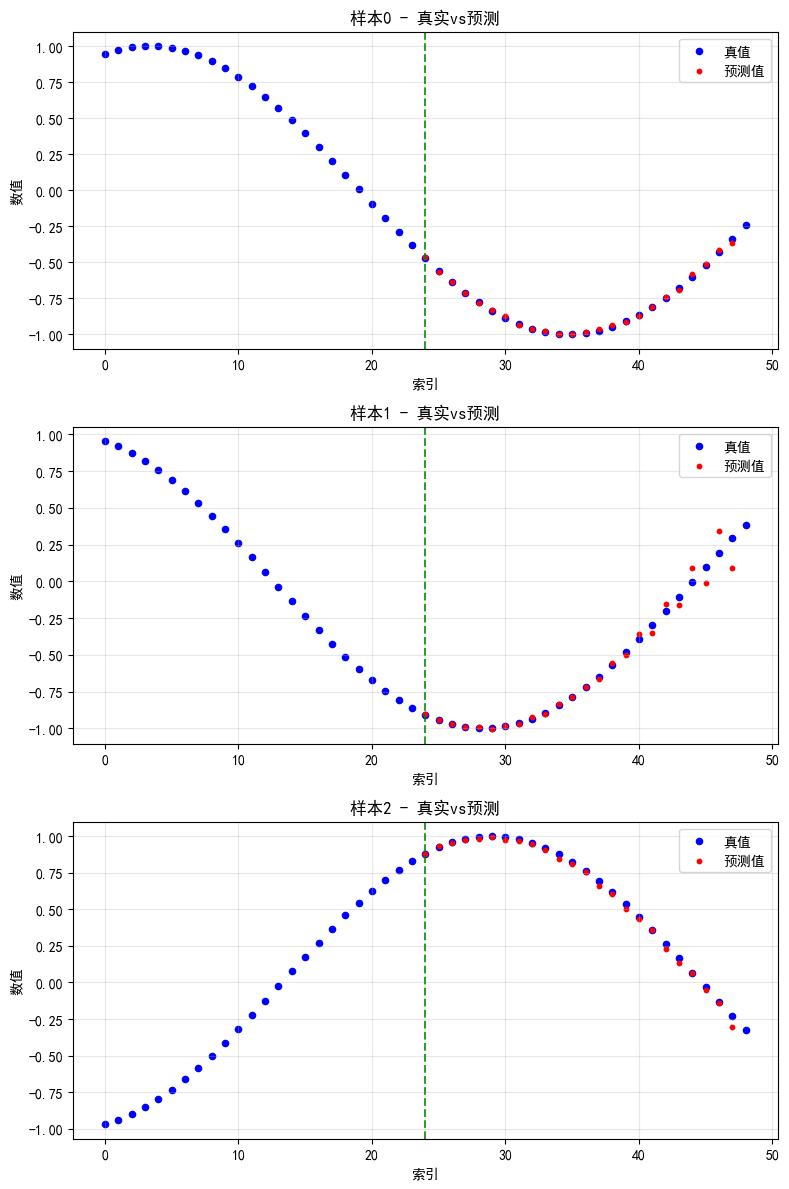

In [125]:
import copy
import matplotlib.pyplot as plt
import numpy as np

model.eval()
test_x = test_x.to(device)
output = model(test_x)

input_x = copy.deepcopy(test_x)
data_list = [test_x]
for i in range(seq_len):
    input_data = input_x[:, i:i+seq_len]
    output_num = model(input_data)
    data_list.append(output_num)
    input_x = torch.cat([input_x, output_num], dim=1)

output_data = torch.cat(data_list, dim=1)

output_data = output_data.detach().to('cpu').numpy()
test_data = test_y.detach().to('cpu').numpy()

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.figure(figsize=(8, 12))

# 按样本拆分到3个子图（i=0/i=1/i=2）
for idx, i in enumerate(range(min(3, len(test_x)))):  # 取前3个样本
    plt.subplot(3, 1, idx+1)
    output_data_i = output_data[i]
    test_data_i = test_data[i]
    test_x_np = np.arange(len(test_data_i))
    output_x_np = np.arange(len(output_data_i))

    plt.scatter(test_x_np, test_data_i, c='blue', label='真值', s=20)
    plt.scatter(output_x_np[seq_len:], output_data_i[seq_len:], c='red', label='预测值', s=10)

    plt.axvline(
        x=seq_len,          # 指定x坐标
        linestyle='--',      # 虚线样式（--虚线，-.点划线，:点线）
        color='green',       # 线条颜色
        linewidth=1.5,       # 线条宽度
        alpha=0.8            # 透明度
    )

    plt.title(f'样本{i} - 真实vs预测', fontsize=12)
    plt.xlabel('索引'), plt.ylabel('数值')
    plt.legend(), plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. **总结**

这是我们遇到的第一个时序任务，同样具有需要关注的空间信息，所以使用卷积来解决也是一个不错的方案。

除此之外，后续会讲到的循环神经网络及其变体同样适合这种任务。